In [1]:
import numpy as np
import pylab as pl
import astropy.units as u
from astropy.time import Time
import scipy.stats as stats

tref_iso = '2021-05-23 00:00:00.000'
tref = Time(tref_iso,format='iso',scale='utc')

RAW 0.20921729560565136
CALIB 0 0.131
CALIB 1 0.121
CALIB 2 0.127


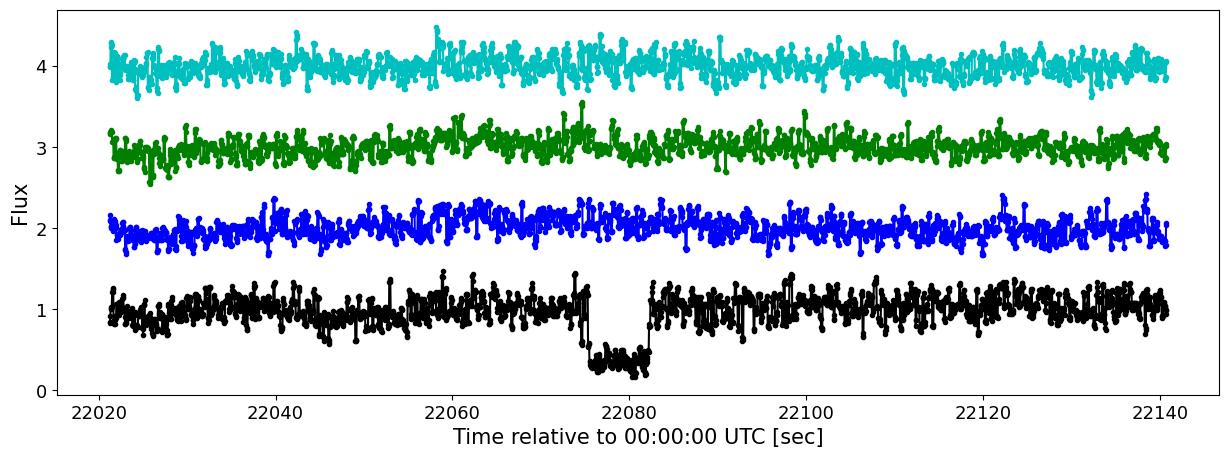

In [2]:
#Nesta parte, o código realiza operações nos dados da fotometria que já foi feita previamente
#converte o tempo para segundos usando o tempo de referência, 
#faz uma normalização na coluna de ft0, que corresponde ao fluxo da estrela alvo (que será ocultada), 
#calcula uma média entre as colunas fc0 (fluxo da estrela calibradora1) e fc2 (fluxo da estrela calibradora 2), e depois a normaliza, nomeando como fc
#e determina o fluxo ft_c (fluxo da estrela alvo em relação às calibradoras) dividindo ft por fc.
#Em seguida, plota um gráfico do Fluxo por Tempo, revelando a ocultação.

inn = 'photometry_OccCebriones_20210523_Olsen (2) - Copia.dat'

t0,ft0,fc0,fc1,fc2 = np.loadtxt(inn, usecols=[3,5,18,30,42], unpack=True)
im_name = np.loadtxt(inn,usecols=[-2],unpack=True,dtype='str')

time0 = (t0 - tref.jd)*u.d.to('s')

ft = ft0/np.median(ft0)
fc = np.array([fc0/np.median(fc0),fc2/np.median(fc2)]).mean(axis=0)

ft_c = ft/fc

pl.figure(figsize=[15,5])
pl.plot(time0,ft,'k.-',zorder=5)
pl.plot(time0,1+fc0/np.median(fc0),'b.-',zorder=1)
pl.plot(time0,2+fc1/np.median(fc1),'g.-',zorder=1)
pl.plot(time0,3+fc2/np.median(fc2),'c.-',zorder=1)


pl.xticks(fontsize=13)
pl.yticks(fontsize=13)
pl.ylabel('Flux',fontsize=15)
pl.xlabel('Time relative to 00:00:00 UTC [sec]',fontsize=15)

print('RAW',ft.std())
print('CALIB 0',np.round((fc0/np.median(fc0)).std(),3))
print('CALIB 1',np.round((fc1/np.median(fc1)).std(),3))
print('CALIB 2',np.round((fc2/np.median(fc2)).std(),3))


In [3]:
#Aqui, o código realiza a binagem, técnica que agrupa uma determinada quantidade de pontos e os substitui por um ponto que esteja na média dos pontos agrupados
#essa técnica ajuda a suavizar os dados e diminuir um pouco os erros.
flux = ft_c
time = time0


binagem = 3

flux_bin, bin_edge, bin_number = stats.binned_statistic(time, flux, 
                                    statistic='mean', 
                                    bins=int(len(flux)/binagem))

time_bin, bin_edge, bin_number = stats.binned_statistic(time, time,
                                    statistic='mean', 
                                    bins=int(len(flux)/binagem))


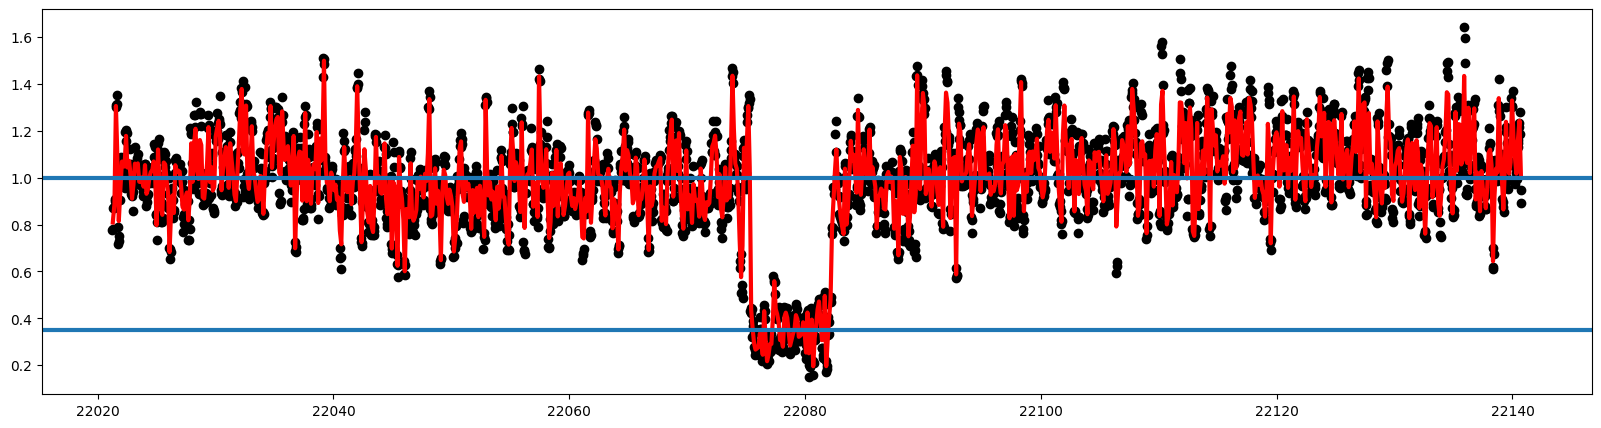

In [4]:
#Aqui começamos a determinar o fluxo que servirá como base para medirmos onde ocorreu a ocultação e o próprio fluxo da ocultação.
fluxo_base=1
fluxo_baixo=0.35

pl.figure(figsize=[20, 5], facecolor='white')
pl.plot(time, flux, 'ko')
pl.plot(time_bin, flux_bin, 'r-', lw=3, ms=10)
pl.axhline(fluxo_base, lw=3)
pl.axhline(fluxo_baixo, lw=3)
pl.show()

In [5]:
#Aqui, criamos uma função chamada modelo, que serve para criar um modelo de fluxo que será ajustado aos dados. 
#Usamos o valor base (fluxo_base) e o valor baixo (fluxo_baixo), que foram definidos acima.
#Quando o valor do fluxo está antes do tempo inicial ou após o tempo final da ocultação , ele tem o mesmo valor que o fluxo_base.
#Quando o valor do fluxo está entre o tempo inicial e o tempo final da ocultação, ele adquire o valor do fluxo_baixo, criando assim um modelo.

def modelo(time0, t_inicio,t_final):
    fluxo_base = 1.0
    fluxo_baixo = 0.35
    f = np.repeat(fluxo_base, len(time0))
    for i in range(len(time0)):
        if(time0[i]>t_inicio) * (time0[i]<t_final):
            f[i]= fluxo_baixo
    
    return f

In [6]:
f_modelo=modelo(time0,22075,22082) #chutes iniciais de quando a ocultação começa e termina.

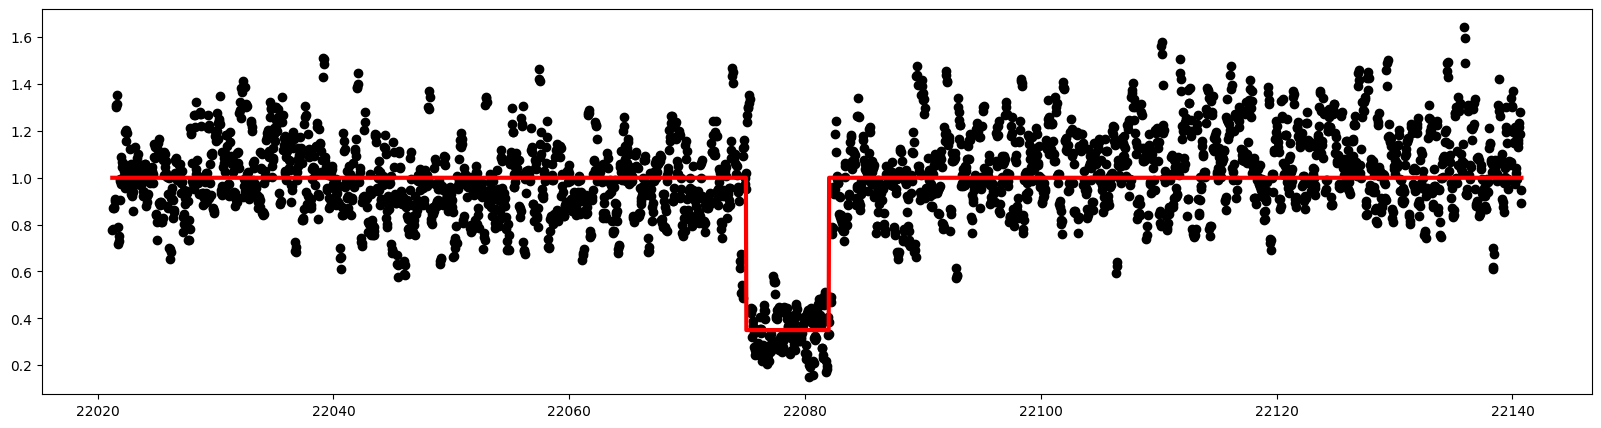

In [7]:
pl.figure(figsize=[20, 5], facecolor='white')
pl.plot(time, flux, 'ko')
pl.plot(time0,f_modelo, 'r-', lw=3)
pl.show()

In [8]:
#Aqui está sendo calculado o Chi2, que avaliará a qualidade do ajuste de acordo com os dados que estamos usando.

sigma=0.1
chi2 = np.sum(((flux - f_modelo)**2)/(sigma**2))
print(chi2/(len(flux)-2))

3.0103032586468363


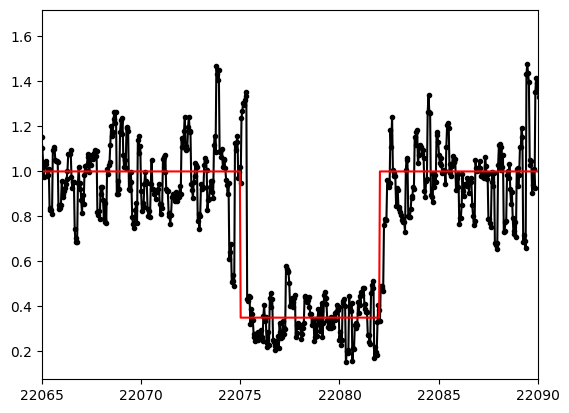

In [9]:
pl.plot(time0, flux, 'k.-')
pl.plot(time0, f_modelo, 'r-')
pl.xlim(22065,22090)
pl.show()

In [10]:
from tqdm import tqdm

In [11]:
#Nesta seção, o código realiza uma análise dos parâmetros do modelo, aplicando diferentes valores de t0 e t1 à fórmula de chi2
#para dessa forma conseguirmos determinar qual o intervalo mais adequado para o modelo.

chi2=np.array([])
t0 = np.random.uniform(22075.0, 22075.423, 10000)
t1 = np.random.uniform(22081.876, 22082.100, 10000)

sigma=0.1

for i in tqdm(range(10000)):
    f_modelo = modelo(time0, t0[i], t1[i])
    chi2=np.append(chi2, np.sum(((flux - f_modelo)**2)/(sigma**2)))
      

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:00<00:00, 165.17it/s]


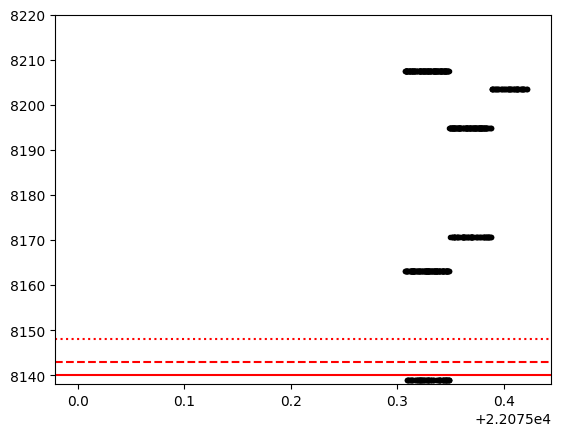

In [12]:
#Plotamos um gráfico de t0 por chi2 e em seguida um gráfico de t1 por chi 2.
#os gráficos têm essa aparência de "degrau" justamente porquê a função não é diferenciável, afetando assim o gráfico de chi2.
#qualquer valor entre um ponto e outro de t0 e t1 pode ser considerado válido quando o chi2 é calculado, mesmo que varie muito, o que cria o formato de linhas contínuas
#o valor que desejamos usar equivale à barra mais baixa, asssim como sua barra de erro. 

pl.plot(t0, chi2, 'k.')
pl.ylim(0.8*chi2.min(), 1.2*chi2.min())
pl.axhline(chi2.min()+1, color='r', ls='-')
pl.axhline(chi2.min()+4, color='r', ls='--')
pl.axhline(chi2.min()+9, color='r', ls=':')
pl.ylim(chi2.min() - 1, chi2.min() + 81)
pl.show()

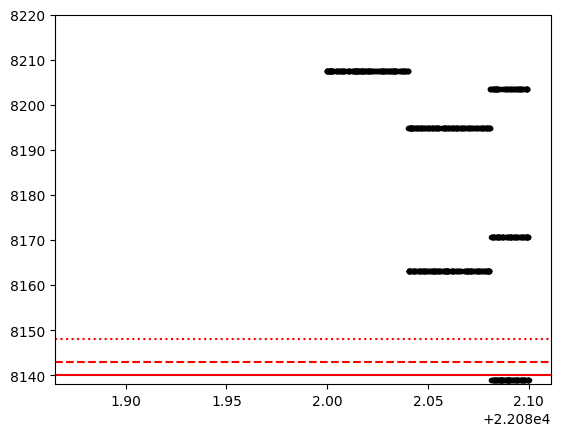

In [13]:
#gráfico de t1 por chi2
pl.plot(t1, chi2, 'k.')
pl.ylim(0.8*chi2.min(), 1.2*chi2.min())
pl.axhline(chi2.min()+1, color='r', ls='-')
pl.axhline(chi2.min()+4, color='r', ls='--')
pl.axhline(chi2.min()+9, color='r', ls=':')
pl.ylim(chi2.min() - 1, chi2.min() + 81)
pl.show()

In [14]:
chi2.argmin()

264

In [15]:
t0[202]

22075.342044594934

In [16]:
t1[202]

22081.943042879488

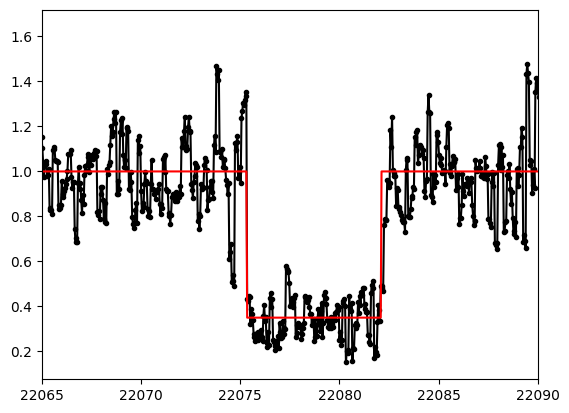

In [17]:
#Plot do gráfico do modelo que mais se adequa aos dados, com o melhor chi2 possível.
pl.plot(time0, flux, 'k.-')
pl.plot(time0, modelo(time0,22075.338,22082.087), 'r-')
pl.xlim(22065,22090)
pl.show()

In [18]:
#Aqui podemos visualizar os valores mínimos e máximos de t0 e t1
print(t0[chi2 < chi2.min() + 1].min())
print(t0[chi2 < chi2.min() + 1].max())

print(t1[chi2 < chi2.min() + 1].min())
print(t1[chi2 < chi2.min() + 1].max())

22075.308561532143
22075.348330163404
22082.081464018633
22082.099968355495


In [19]:
#E por fim, os melhores valores de t0 e t1, respectivamente, junto de suas incertezas. :)
print('1sigma (68,3%) t0')
print('Valor    :', (t0[chi2 < chi2.min() + 1].max() + 
                     t0[chi2 < chi2.min() + 1].min())/2.)
print('Incerteza:', (t0[chi2 < chi2.min() + 1].max() - 
                     t0[chi2 < chi2.min() + 1].min())/2.)
print('\n')

print('1sigma (68,3%) t1')
print('Valor    :', (t1[chi2 < chi2.min() + 1].max() + 
                     t1[chi2 < chi2.min() + 1].min())/2.)
print('Incerteza:', (t1[chi2 < chi2.min() + 1].max() - 
                     t1[chi2 < chi2.min() + 1].min())/2.)

1sigma (68,3%) t0
Valor    : 22075.328445847772
Incerteza: 0.01988431563040649


1sigma (68,3%) t1
Valor    : 22082.090716187064
Incerteza: 0.009252168430975871
